# Imports

In [1]:
import os
import torch
import numpy as np
import torch
import time
from PIL import Image
import os
import numpy as np
from torchvision import transforms as t
import pyexr
from torch import nn
from torch.utils import data
import pytorch_msssim
import matplotlib.pyplot as plt

# Dataloader

In [2]:
class ShadingDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir, dataset_part="training", overfit=False, return_meta=False):
        
        print("Building dataset...")
        t0 = time.time()

        # Params
        self.dataset_dir = dataset_dir
        self.dataset_part = dataset_part
        self.overfit = overfit

        self.files_normal = []
        self.files_wsnormal = []
        self.files_position = []
        self.files_ground_truth = []
        self.set_files()

        self.dataset_size = len(self.files_normal)

        print(f"{self.__class__.__name__}: {dataset_part}  build complete!")
        print("Elapsed: {} seconds.".format(time.time() - t0))
        print("Dataset size: ", self.dataset_size)

    def __len__(self):
        return self.dataset_size

    def set_files(self):
        
        normal_txt = os.path.join(self.dataset_dir,'datasets', f'{self.dataset_part}_normal.txt')
        with open(normal_txt) as f:
            lines = f.readlines()
            for line in lines:
                
                if line.split('/')[0] == "VikingVillage":
                    continue
                
                self.files_normal.append(line.split(' ')[0])
        
        wsnormal_txt = os.path.join(self.dataset_dir,'datasets', f'{self.dataset_part}_wsnormal.txt')
        with open(wsnormal_txt) as f:
            lines = f.readlines()
            for line in lines:
                
                if line.split('/')[0] == "VikingVillage":
                    continue
                    
                self.files_wsnormal.append(line.split(' ')[0])
         
                
        position_txt = os.path.join(self.dataset_dir,'datasets', f'{self.dataset_part}_position.txt')
        with open(position_txt) as f:
            lines = f.readlines()
            for line in lines:
                
                if line.split('/')[0] == "VikingVillage":
                    continue
                    
                self.files_position.append(line.split(' ')[0])
        

        ground_truth_txt = os.path.join(self.dataset_dir,'datasets', f'{self.dataset_part}_groundtruth.txt')
        with open(ground_truth_txt) as f:
            lines = f.readlines()
            for line in lines:                
                if line.split('/')[0] == "VikingVillage":
                    continue
                
                self.files_ground_truth.append(line.split(' ')[0])
                
                
        if self.overfit:
            # Fits to first 16 images
            self.files_normal = self.files_normal[:16]
            self.files_wsnormal = self.files_wsnormal[:16]
            self.files_position = self.files_position[:16]
            self.files_ground_truth = self.files_ground_truth[:16]
        
                
    def read_exr(self,filename):
        
        file = torch.Tensor(pyexr.read(filename))[:,:,:3].permute(2,0,1)
        
        return file

        
    def __getitem__(self, idx):
        
        normal = self.read_exr(os.path.join(self.dataset_dir,self.files_normal[idx]))
        wsnormal = self.read_exr(os.path.join(self.dataset_dir,self.files_wsnormal[idx]))
        position = self.read_exr(os.path.join(self.dataset_dir,self.files_position[idx]))
        gt = self.read_exr(os.path.join(self.dataset_dir,self.files_ground_truth[idx]))

        
        return normal, wsnormal, position, gt
       

# Model

In [3]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):

    def __init__(self, input_ch, output_ch):
        super().__init__()
                
        self.dconv_down1 = double_conv(input_ch, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, output_ch, 1)
        
        
    def forward(self, x):
        
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

# Training Setup - Overfit

In [4]:
dataset_dir = '/media/kuavg/CaganSSD/DeepShading/directional-occlusion'

In [25]:
# Load dataset -- Overfit test.
trn_dataset = ShadingDataset(dataset_dir=dataset_dir, dataset_part="training", overfit=True)
val_dataset = ShadingDataset(dataset_dir=dataset_dir, dataset_part="validation", overfit=True)

loaders = {}
loaders['train'] = data.DataLoader(trn_dataset, batch_size=16, shuffle=False, num_workers=10, drop_last=True, pin_memory=True)
loaders['val'] = data.DataLoader(trn_dataset, batch_size=16, shuffle=False, num_workers=10, drop_last=True, pin_memory=True)

# To make the training fast.
torch.backends.cudnn.benchmark = True

# Set device
device = torch.device('cuda:0')

# Model setup
model = UNet(input_ch=9, output_ch=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
epochs = 1000
val_interval = 100
mssim_loss = pytorch_msssim.MSSSIM()

Building dataset...
ShadingDataset: training  build complete!
Elapsed: 0.14015865325927734 seconds.
Dataset size:  16
Building dataset...
ShadingDataset: validation  build complete!
Elapsed: 0.02281665802001953 seconds.
Dataset size:  16


# Training Setup - Full

In [5]:
# Load dataset
trn_dataset = ShadingDataset(dataset_dir=dataset_dir, dataset_part="training")
val_dataset = ShadingDataset(dataset_dir=dataset_dir, dataset_part="validation")

loaders = {}
loaders['train'] = data.DataLoader(trn_dataset, batch_size=16, shuffle=True, num_workers=10, drop_last=True, pin_memory=True)
loaders['val'] = data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=10, drop_last=True, pin_memory=True)

# To make the training fast.
torch.backends.cudnn.benchmark = True

# Set device
device = torch.device('cuda:0')

# Model setup
model = UNet(input_ch=9, output_ch=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
epochs = 10
val_interval = 1
mssim_loss = pytorch_msssim.MSSSIM()

Building dataset...
ShadingDataset: training  build complete!
Elapsed: 0.150498628616333 seconds.
Dataset size:  54060
Building dataset...
ShadingDataset: validation  build complete!
Elapsed: 0.012239456176757812 seconds.
Dataset size:  6000


# Training loop

Starting model training...
Epoch: 1 [15984/54060 (30%)]	Loss: 0.126058
Epoch: 1 [31984/54060 (59%)]	Loss: 0.111869
Epoch: 1 [47984/54060 (89%)]	Loss: 0.099850
(val) Epoch: 1 [1584/6000 (26%)]	Loss: 0.103923
(val) Epoch: 1 [3184/6000 (53%)]	Loss: 0.107179
(val) Epoch: 1 [4784/6000 (80%)]	Loss: 0.106222
Epoch: 1 , TrainLoss: 0.12497540364398133 , ValLoss: 0.10548254823684693
Saving model...
Plotting...
Epoch: 2 [15984/54060 (30%)]	Loss: 0.103370
Epoch: 2 [31984/54060 (59%)]	Loss: 0.101141
Epoch: 2 [47984/54060 (89%)]	Loss: 0.091155
(val) Epoch: 2 [1584/6000 (26%)]	Loss: 0.128392
(val) Epoch: 2 [3184/6000 (53%)]	Loss: 0.098451
(val) Epoch: 2 [4784/6000 (80%)]	Loss: 0.094467
Epoch: 2 , TrainLoss: 0.1001763122014 , ValLoss: 0.09506898244222005
Saving model...
Plotting...
Epoch: 3 [15984/54060 (30%)]	Loss: 0.089099
Epoch: 3 [31984/54060 (59%)]	Loss: 0.090187
Epoch: 3 [47984/54060 (89%)]	Loss: 0.091754
(val) Epoch: 3 [1584/6000 (26%)]	Loss: 0.095958
(val) Epoch: 3 [3184/6000 (53%)]	Loss: 0.08

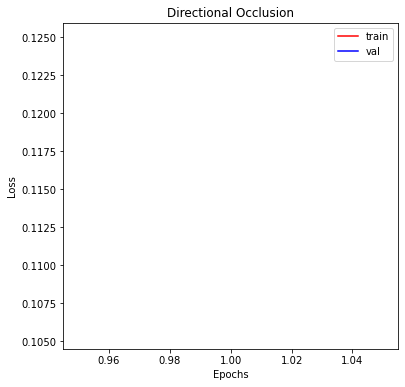

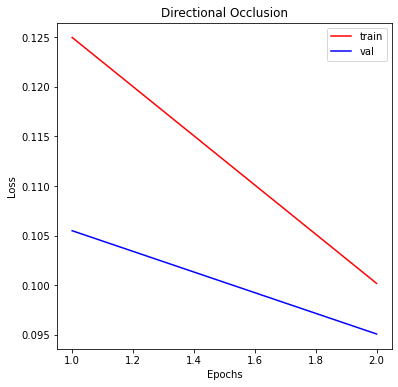

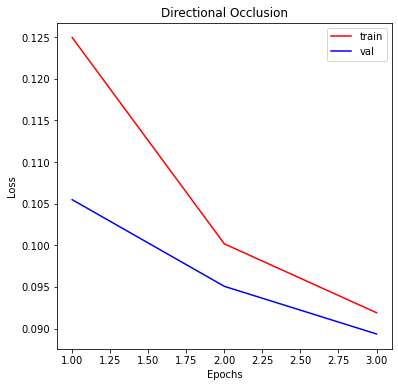

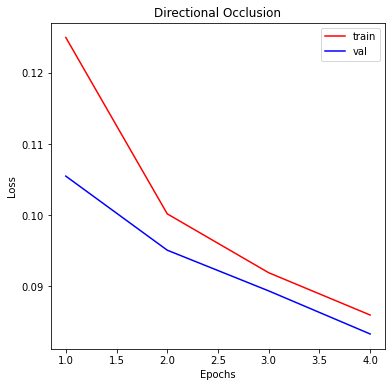

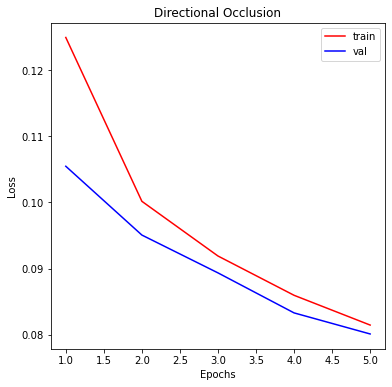

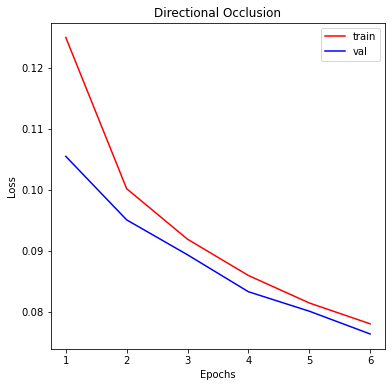

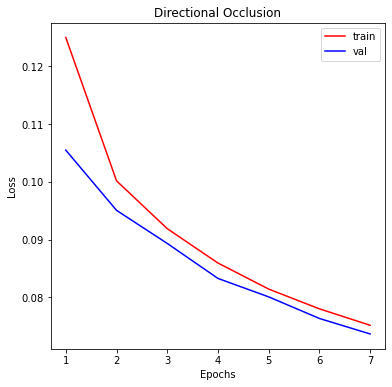

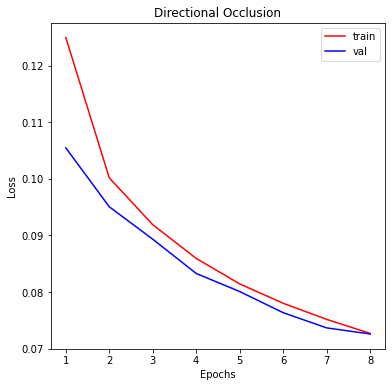

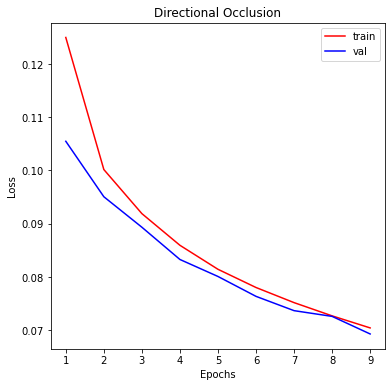

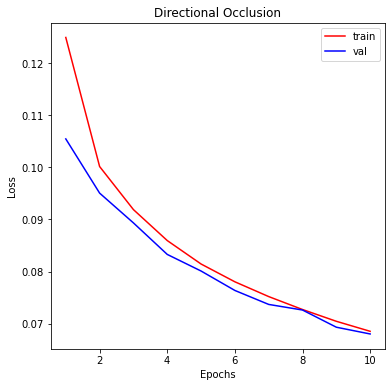

In [7]:
print("Starting model training...")
val_losses, val_lbls= [], []
trn_losses, trn_lbls = [], []
best_val_loss = 1000000

for epoch in range(1, epochs + 1):

    model.train()
    train_loss = 0.0
    cnt = 0

    for batch_idx, data_batch in enumerate(loaders['train']):
        # Zero out the gradients
        optimizer.zero_grad()
        normal, wsnormal, position, gt = data_batch        
        in_feats = torch.cat([normal.to(device), wsnormal.to(device), position.to(device)], dim=1)
        out = model(in_feats)
        
        loss = 1-mssim_loss(out, gt.to(device))

        # Optimize
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        cnt +=1
        
        if cnt % 1000 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data_batch[0]),
                                                                     len(loaders['train'].dataset),
                                                                     100. * batch_idx / len(loaders['train']),
                                                                     loss.item()))
    # Calc avg and save it.
    train_loss /= cnt
    trn_losses.append(train_loss)
    trn_lbls.append(epoch)

    # Validation loop
    if (epoch % val_interval)== 0 or epoch == 1:
        
        with torch.no_grad():
        
            model.eval()

            val_loss = 0.0
            cnt = 0

            for batch_idx, data_batch in enumerate(loaders['val']):

                normal, wsnormal, position, gt = data_batch        
                in_feats = torch.cat([normal.to(device), wsnormal.to(device), position.to(device)], dim=1)
                
                #print("normal: ", normal.shape, " wsnormal: ", wsnormal.shape, " position: " , position.shape, " gt: ", gt.shape)
                out = model(in_feats)
                loss = 1 - mssim_loss(out, gt.to(device))

                val_loss += loss.item()
                cnt +=1
                if cnt % 100 == 0:
                    print('(val) Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data_batch[0]),
                            len(loaders['val'].dataset), 100. * batch_idx / len(loaders['val']), loss.item()))

            # Calc avg
            val_loss /= cnt
            val_losses.append(val_loss)
            val_lbls.append(epoch)

            print(f'Epoch: {epoch} , TrainLoss: {train_loss} , ValLoss: {val_loss}')
            if val_loss < best_val_loss:
                print("Saving model...")
                torch.save(model.state_dict(), f"./model/checkpoints/directional_occlusion_{epoch}.pth")
                best_val_loss = val_loss

        print("Plotting...")
        import matplotlib.pyplot as plt
        fig, axs = plt.subplots(1, 1, figsize=(6, 6))
        axs.plot(np.array(trn_lbls), np.array(trn_losses),  label='train', color="red")
        axs.plot(np.array(val_lbls), np.array(val_losses),  label='val', color="blue")
        axs.set_ylabel('Loss')
        axs.set_xlabel('Epochs')
        axs.set_title('Directional Occlusion')
        axs.legend()
        fig.savefig(f"./model/plots/directional_occlusion_{epoch}.png")

# Visualization

In [8]:
def to_img(img):
    return img[0].cpu().numpy().transpose(1, 2, 0)

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
tst_dataset = ShadingDataset(dataset_dir=dataset_dir, dataset_part="test")
loaders['tst'] = data.DataLoader(tst_dataset, batch_size=1, shuffle=False, num_workers=10, drop_last=True, pin_memory=False)

model = UNet(input_ch=9, output_ch=3).to(device)
model.load_state_dict(torch.load('./model/checkpoints/directional_occlusion_full/directional_occlusion_10.pth'))

tst_loss = 0.
cnt = 0

with torch.no_grad():
    
    for batch_idx, data_batch in enumerate(loaders['tst']):
        model.eval()
        
        normal, wsnormal, position, gt = data_batch        
        in_feats = torch.cat([normal.to(device), wsnormal.to(device), position.to(device)], dim=1)
                
        #print("normal: ", normal.shape, " wsnormal: ", wsnormal.shape, " position: " , position.shape, " gt: ", gt.shape)
        out = model(in_feats)
        loss = 1 - mssim_loss(out, gt.to(device))

        tst_loss += loss
        cnt += 1

        fig, axs = plt.subplots(1, 5, figsize=(20, 5))
        axs[0].imshow(to_img(normal))
        axs[0].set_title('Normal')

        axs[1].imshow(to_img(wsnormal))
        axs[1].set_title('WSNormal')

        axs[2].imshow(to_img(position))
        axs[2].set_title('Position')

        axs[3].imshow(to_img(gt))
        axs[3].set_title('GT')

        axs[4].imshow(to_img(out.detach()))
        axs[4].set_title('Pred')
        fig.savefig(f"./model/visuals/directional_occlusion_full/directional_occlusion_{batch_idx}.png")
        plt.close(fig)
        
print(tst_loss/cnt)

Building dataset...
ShadingDataset: test  build complete!
Elapsed: 0.005887746810913086 seconds.
Dataset size:  999


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor(0.0904, device='cuda:0')


In [12]:
print("Test SSIM: " , 1 - tst_loss/cnt)

Test SSIM:  tensor(0.9096, device='cuda:0')
